In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.dates as mdate
import time
import datetime
from datetime import datetime
from time import mktime
np.set_printoptions(precision=6)
pd.set_option('display.float_format',lambda x : '%.6f' % x)

loading data

In [2]:
df = pd.read_csv('GOOG_2020-07-01.txt', header = None, names = ['Date&Time', 'Close', 'NAME'],index_col = 3)
df.set_index(np.arange(0,df.shape[0],1),inplace=True)
df

,Date&Time,Close,NAME
0,2020-07-01 04:16:07:301,1413.610000,1
1,2020-07-01 04:21:17:549,1414.010000,50
2,2020-07-01 05:10:42:852,1413.940000,1
3,2020-07-01 05:16:15:159,1413.940000,17
4,2020-07-01 05:16:15:159,1413.940000,50
...,...,...,...
63634,2020-07-01 19:59:26:931,1439.750000,2
63635,2020-07-01 19:59:26:931,1440.050000,1
63636,2020-07-01 19:59:26:931,1440.050000,1
63637,2020-07-01 19:59:26:931,1440.060000,1


Viewing data 2022-7-1 00:00:00.000 to 2022-7-31 00:00:00.000

In [3]:
df = df.drop_duplicates(subset=['Date&Time'])
df = df.reset_index()[['Date&Time', 'Close']]
df

,Date&Time,Close
0,2020-07-01 04:16:07:301,1413.610000
1,2020-07-01 04:21:17:549,1414.010000
2,2020-07-01 05:10:42:852,1413.940000
3,2020-07-01 05:16:15:159,1413.940000
4,2020-07-01 05:16:15:163,1415.980000
...,...,...
34548,2020-07-01 19:55:19:124,1440.000000
34549,2020-07-01 19:57:28:362,1437.040000
34550,2020-07-01 19:59:26:930,1440.000000
34551,2020-07-01 19:59:26:931,1440.050000


Summary Stats

In [4]:
df.describe()

,Close
count,34553.000000
mean,1431.779231
std,8.065919
min,1402.010000
25%,1428.500000
50%,1434.240000
75%,1437.250000
max,1443.130000


General Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34553 entries, 0 to 34552
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date&Time  34553 non-null  object 
 1   Close      34553 non-null  float64
dtypes: float64(1), object(1)
memory usage: 540.0+ KB


In [6]:
# plt.figure(figsize=(15, 6))
# plt.subplots_adjust(top=1.25, bottom=1.2)
# x = df['Date&Time']
# y = df['Close']
# plt.plot(x,y)
# plt.ylabel('Close')
# plt.xlabel('Date&Time')
# plt.title("EUR_USD")
    
# plt.show()

train test split
train set / test set := 0.8 / 0.2

type -> timestamp

In [7]:
df['Date&Time'].replace('-','/')
# print(df)
bb = []
for i in range(len(df['Date&Time'])):
#     df.loc[i, 'Date&Time'] = df.loc[i, 'Date&Time'][-12:]
    df.loc[i, 'Date&Time'] = df.loc[i, 'Date&Time'].replace('-','/')
    a = datetime.strptime(df.loc[i, 'Date&Time'], "%Y/%m/%d %H:%M:%S:%f")
    tuple = a.timetuple()
    timestamp = time.mktime(tuple)
    bb.append(timestamp)
    
df['Timestamp'] = bb
    
print(df)

                     Date&Time       Close         Timestamp
0      2020/07/01 04:16:07:301 1413.610000 1593594967.000000
1      2020/07/01 04:21:17:549 1414.010000 1593595277.000000
2      2020/07/01 05:10:42:852 1413.940000 1593598242.000000
3      2020/07/01 05:16:15:159 1413.940000 1593598575.000000
4      2020/07/01 05:16:15:163 1415.980000 1593598575.000000
...                        ...         ...               ...
34548  2020/07/01 19:55:19:124 1440.000000 1593651319.000000
34549  2020/07/01 19:57:28:362 1437.040000 1593651448.000000
34550  2020/07/01 19:59:26:930 1440.000000 1593651566.000000
34551  2020/07/01 19:59:26:931 1440.050000 1593651566.000000
34552  2020/07/01 19:59:44:328 1437.110000 1593651584.000000

[34553 rows x 3 columns]


In [8]:

df = df.drop_duplicates(subset=['Timestamp'])
df = df.reset_index()[['Date&Time', 'Close','Timestamp']]
df

,Date&Time,Close,Timestamp
0,2020/07/01 04:16:07:301,1413.610000,1593594967.000000
1,2020/07/01 04:21:17:549,1414.010000,1593595277.000000
2,2020/07/01 05:10:42:852,1413.940000,1593598242.000000
3,2020/07/01 05:16:15:159,1413.940000,1593598575.000000
4,2020/07/01 05:20:21:710,1413.650000,1593598821.000000
...,...,...,...
13102,2020/07/01 19:53:27:685,1439.260000,1593651207.000000
13103,2020/07/01 19:55:19:123,1440.000000,1593651319.000000
13104,2020/07/01 19:57:28:362,1437.040000,1593651448.000000
13105,2020/07/01 19:59:26:930,1440.000000,1593651566.000000


here is timestamp

In [9]:
print(type(df.loc[1, 'Date&Time']))

<class 'str'>


0        2020/07/01 04:16:07:301
1        2020/07/01 04:21:17:549
2        2020/07/01 05:10:42:852
3        2020/07/01 05:16:15:159
4        2020/07/01 05:20:21:710
                  ...           
13102    2020/07/01 19:53:27:685
13103    2020/07/01 19:55:19:123
13104    2020/07/01 19:57:28:362
13105    2020/07/01 19:59:26:930
13106    2020/07/01 19:59:44:328
Name: Date&Time, Length: 13107, dtype: object


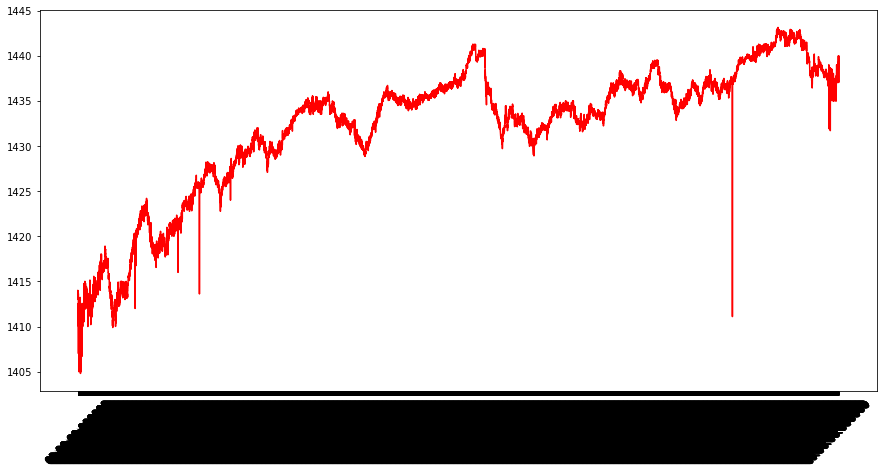

In [10]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%H:%M:%S:%f'))                 

# plt.xticks(pd.date_range(df.loc[0, 'Date&Time'], df.loc[len(df['Date&Time']), 'Date&Time'], freq='H'),rotation=45)

print(df['Date&Time'])

ax.plot(df['Date&Time'], df['Close'],color='r')
plt.xticks(rotation=45)
plt.show()


In [11]:
# train_set, test_set = train_test_split(df, test_size = 0.1)
# train_set = train_set.reset_index()[['Date&Time', 'Close']]
# test_set = test_set.reset_index()[['Date&Time', 'Close']]
# train_set.sort_values(by='Date&Time')
# test_set.sort_values(by='Date&Time')
train_len = (len(df) // 10) * 9
print(train_len)
train_set = df.loc[: train_len]
test_set = df.loc[train_len:]
test_set = test_set.reset_index()[['Date&Time', 'Close','Timestamp']]
print(df)
print('train_set:\n', train_set)
print('test_set:\n', test_set)

11790
                     Date&Time       Close         Timestamp
0      2020/07/01 04:16:07:301 1413.610000 1593594967.000000
1      2020/07/01 04:21:17:549 1414.010000 1593595277.000000
2      2020/07/01 05:10:42:852 1413.940000 1593598242.000000
3      2020/07/01 05:16:15:159 1413.940000 1593598575.000000
4      2020/07/01 05:20:21:710 1413.650000 1593598821.000000
...                        ...         ...               ...
13102  2020/07/01 19:53:27:685 1439.260000 1593651207.000000
13103  2020/07/01 19:55:19:123 1440.000000 1593651319.000000
13104  2020/07/01 19:57:28:362 1437.040000 1593651448.000000
13105  2020/07/01 19:59:26:930 1440.000000 1593651566.000000
13106  2020/07/01 19:59:44:328 1437.110000 1593651584.000000

[13107 rows x 3 columns]
train_set:
                      Date&Time       Close         Timestamp
0      2020/07/01 04:16:07:301 1413.610000 1593594967.000000
1      2020/07/01 04:21:17:549 1414.010000 1593595277.000000
2      2020/07/01 05:10:42:852 1413.94000

Normalization

In [12]:
# scaler = MinMaxScaler(feature_range=(0,1))
# train_set_scaled = scaler.fit_transform(train_set[:,1].reshape(-1,1))

a = np.array(train_set['Close'])
a = a[:,None]
print(a.shape)
b = np.array(train_set['Timestamp'])
b = b[:,None]
train_set_scaled = np.hstack((a,b))

train_set_scaled

(11791, 1)


array([[1.413610e+03, 1.593595e+09],
       [1.414010e+03, 1.593595e+09],
       [1.413940e+03, 1.593598e+09],
       ...,
       [1.440990e+03, 1.593636e+09],
       [1.440690e+03, 1.593636e+09],
       [1.440720e+03, 1.593636e+09]])

test set should start from the sixtieth countdown of the train set 
so that the first one of test set can be predicted. 
so now after appending 60 items from train set before the test test,
the new test set should be as following.

In [13]:
# test_set_scaled = scaler.fit_transform(test_set[:,1].reshape(-1,1))
a = np.array(test_set['Close'])
a = a[:,None]

b = np.array(test_set['Timestamp'])
b = b[:,None]
test_set_scaled = np.hstack((a,b))


# test_set_scaled = np.squeeze(test_set['Close'])
# last_sixty = train_set_scaled[-10:]
# last_sixty = np.squeeze(last_sixty)
# test_set_scaled = np.append(last_sixty, test_set_scaled, axis = 0)
# test_set_scaled = np.array(test_set_scaled)
print(test_set_scaled.shape)
len(test_set_scaled)
# print(train_set_scaled[-10] == test_set_scaled[0])



(1317, 2)


1317

establish specific train set features and labels for LSTM
train_feature ----- the 50 items before the label
train_label ----- decided by the 60 items before itself

In [14]:
train_feature = []
train_label = []

for i in range(10, len(train_set_scaled)):
    train_feature.append(train_set_scaled[i-10:i, 0])
    train_label.append(train_set_scaled[i, 0])

train_feature, train_label = np.array(train_feature), np.array(train_label)
# train_feature = np.reshape(train_feature, (train_feature.shape[0], train_feature.shape[1], 1))
# train_feature = np.squeeze(train_feature)
print('train_feature:\n', train_feature)
print('train_label:\n', train_label)
# type(train_feature)

train_feature:
 [[1413.61   1414.01   1413.94   ... 1413.64   1413.     1413.64  ]
 [1414.01   1413.94   1413.94   ... 1413.     1413.64   1413.64  ]
 [1413.94   1413.94   1413.65   ... 1413.64   1413.64   1413.64  ]
 ...
 [1440.795  1440.795  1440.795  ... 1440.93   1440.7124 1440.69  ]
 [1440.795  1440.795  1440.795  ... 1440.7124 1440.69   1440.99  ]
 [1440.795  1440.795  1441.0458 ... 1440.69   1440.99   1440.69  ]]
train_label:
 [1413.64 1413.64 1407.   ... 1440.99 1440.69 1440.72]


establish specific test set features without labels for LSTM
testing_feature ----- the 50 items before the one which need to be predicted after these 60 items


In [15]:
test_feature = []
test_label = []

for i in range(10, len(test_set_scaled)):
    test_feature.append(test_set_scaled[i-10:i, 0])
    test_label.append(test_set_scaled[i, 0])
    
test_feature, test_label = np.array(test_feature), np.array(test_label)
# test_feature = np.reshape(test_feature, (test_feature.shape[0], test_feature.shape[1], 1))
# test_feature = np.squeeze(test_feature)
print(test_feature.shape)
print('test_feature:\n', test_feature)
print('test_label:\n', test_label)

(1307, 10)
test_feature:
 [[1440.72   1440.775  1440.975  ... 1440.8537 1440.98   1440.7   ]
 [1440.775  1440.975  1440.9805 ... 1440.98   1440.7    1440.61  ]
 [1440.975  1440.9805 1440.7101 ... 1440.7    1440.61   1440.5783]
 ...
 [1438.55   1439.     1438.     ... 1439.26   1439.26   1440.    ]
 [1439.     1438.     1439.255  ... 1439.26   1440.     1437.04  ]
 [1438.     1439.255  1439.     ... 1440.     1437.04   1440.    ]]
test_label:
 [1440.61   1440.5783 1440.61   ... 1437.04   1440.     1437.11  ]


In [16]:
# train_feature, train_label, test_feature, test_label
train_feature = tf.convert_to_tensor(train_feature)
train_feature                                                                      

2022-08-11 10:26:32.817541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11211 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0004:05:00.0, compute capability: 7.0


<tf.Tensor: shape=(11781, 10), dtype=float64, numpy=
array([[1413.61  , 1414.01  , 1413.94  , ..., 1413.64  , 1413.    ,
        1413.64  ],
       [1414.01  , 1413.94  , 1413.94  , ..., 1413.    , 1413.64  ,
        1413.64  ],
       [1413.94  , 1413.94  , 1413.65  , ..., 1413.64  , 1413.64  ,
        1413.64  ],
       ...,
       [1440.795 , 1440.795 , 1440.795 , ..., 1440.93  , 1440.7124,
        1440.69  ],
       [1440.795 , 1440.795 , 1440.795 , ..., 1440.7124, 1440.69  ,
        1440.99  ],
       [1440.795 , 1440.795 , 1441.0458, ..., 1440.69  , 1440.99  ,
        1440.69  ]])>

establish our custom LSTM model

In [46]:
model = keras.Sequential()
# batch_input_shape=(None,1,9)
model.add(layers.LSTM(256, activation = 'relu', return_sequences = True, input_shape = (train_feature.shape[1], 1)))
model.add(layers.LSTM(256, activation = 'relu', return_sequences = True))
model.add(layers.LSTM(256, activation = 'relu', return_sequences = False))
# model.add(layers.Dense(20, activation = 'linear'))
model.add(layers.Dense(1,activation = 'linear'))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 256)           264192    
                                                                 
 lstm_9 (LSTM)               (None, 10, 256)           525312    
                                                                 
 lstm_10 (LSTM)              (None, 256)               525312    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


define the optimizar and loss
we always choose adam which is one of the most popular optimizar to tune the model
and MSE which we always used in most DL model to represent the results of loss function

train the model

In [47]:
# model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_feature, train_label, batch_size=16, epochs=30, verbose=1)
#  validation_data=(test_feature, test_label)

Epoch 1/30
737/737 [==============================] - 69s 90ms/step - loss: 222207.8281
Epoch 2/30
737/737 [==============================] - 66s 90ms/step - loss: 3.0914
Epoch 3/30
737/737 [==============================] - 66s 90ms/step - loss: 251.5778
Epoch 4/30
737/737 [==============================] - 66s 90ms/step - loss: 187.4366
Epoch 5/30
737/737 [==============================] - 66s 90ms/step - loss: 169.3594
Epoch 6/30
737/737 [==============================] - 66s 90ms/step - loss: 149.1075
Epoch 7/30
737/737 [==============================] - 66s 90ms/step - loss: 65.4345
Epoch 8/30
737/737 [==============================] - 66s 90ms/step - loss: 3810.4990
Epoch 9/30
737/737 [==============================] - 66s 90ms/step - loss: 0.5621
Epoch 10/30
737/737 [==============================] - 66s 90ms/step - loss: 0.8920
Epoch 11/30
737/737 [==============================] - 66s 90ms/step - loss: 1.5744
Epoch 12/30
737/737 [==============================] - 66s 90ms/step

prediction on test set

In [48]:
pred = model.predict(test_feature, verbose = 0)
print(pred)
rmse = np.sqrt(np.mean(((pred - test_label)**2)))
rmse

[[1433.4524]
 [1433.425 ]
 [1433.4355]
 ...
 [1431.8243]
 [1430.6376]
 [1432.3123]]


7.902882682120121

visualize the prediction and compare it with the real ones

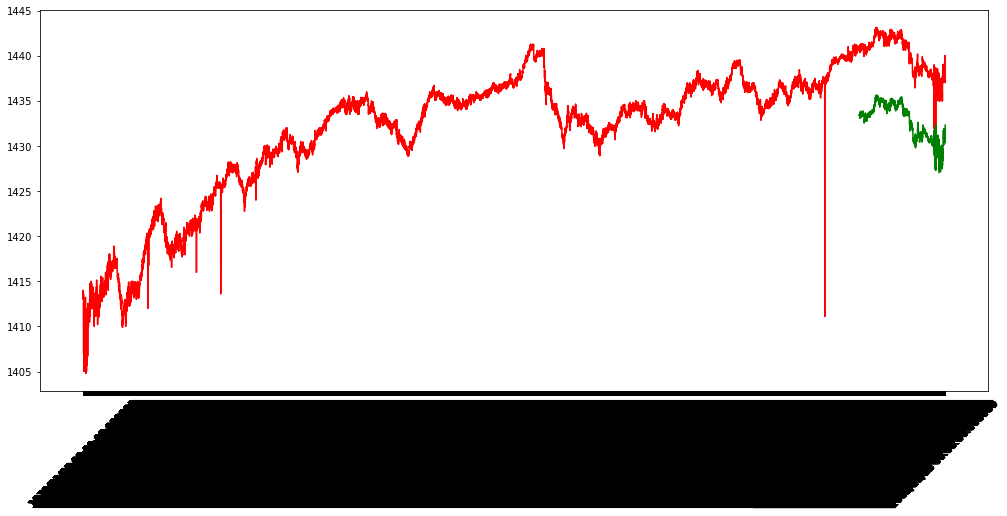

In [49]:
# yy = model.predict(train_feature)
fig = plt.figure(figsize=(17, 7))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y/%m/%d %H:%M:%S:%f'))                 


ax.plot(df['Date&Time'], df['Close'],color='r')

ax.plot(test_set.loc[10:,'Date&Time'], pred, color = 'g')

plt.xticks(rotation=45)
plt.show()



             

# # plt.xticks(pd.date_range(df.loc[0, 'Date&Time'], df.loc[len(df['Date&Time']), 'Date&Time'], freq='H'),rotation=45)

In [50]:
ddf = pd.DataFrame(test_set.loc[10:,'Close'])
ddf['pred'] = pred
ddf.head(100)

,Close,pred
10,1440.610000,1433.452393
11,1440.578300,1433.425049
12,1440.610000,1433.435547
13,1440.764500,1433.341675
14,1440.855000,1433.457520
...,...,...
105,1440.320000,1433.581787
106,1440.488400,1433.577515
107,1440.450000,1433.479370
108,1440.320000,1433.258545
